# Empathy TextGAIL Model

- Input: Prompt-Response custom compiled dataset
  - Prompt: Sourced from various dialogue datasets including EmpatheticDialogues, DailyDialogue, and OMG-Empathy datasets
  - Response: Set of predefined output "classes" that vaguely correspond to emotions

- Output: Response in the form of one of the output "classes" based on the general emotion that an empathetic responder would use when responding

Parts of the implementation of the model is based on the June 2020 Paper *TextGAIL: Generative Adversarial
Imitation Learning for Text Generation* by Qingyang Wu, Lei Li, and Zhou Yu ([paper link](https://arxiv.org/pdf/2004.13796.pdf))


## Model Architecture

Learning to generate text or working in domains that utilize large volumes of text (like empathetic chatbots) requires highly advanced models typically developed by NLP researchers. I decided to leverage previous works within the Generator and Discriminator networks of the architecture to handle the textual generation and understanding goals we had set in mind. There are two such pre-trained models used in this architecture: RoBERTa and GPT-2. 

## RoBERTa

[RoBERTa Paper](https://arxiv.org/pdf/1907.11692.pdf)

RoBERTa stands for A **R**obustly **O**ptimized ***BERT*** Pretraining ***A***pproach. RoBERTa serves as the classifier for the Discriminator network. Using a classifier that is a pretrained NLP model is effective because we need to have effective rewards coming from the discriminator so that the generator can train properly. However, the issue with using a pretrained model like RoBERTa is that the output is not a binary number or even in the range [0,1]. Instead RoBERTa outputs a set of high-level sentence embeddings, similar to the famous Google BERT. In fact, the architecture of RoBERTa is nearly identical to BERT. RoBERTa is simply a faster, better version of BERT, the bidirectional transformer developed by Google in 2016 for language generation/translation. This implementation uses RoBERTa-base with 125 million parameters.

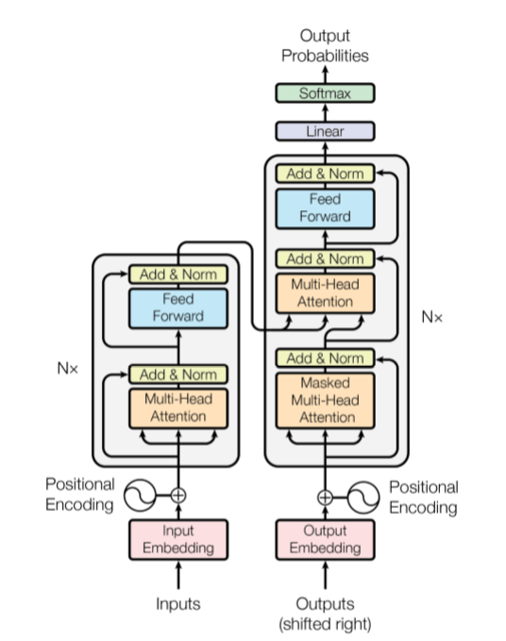



In order to get a classification output from RoBERTa, I borrowed the technique used in the TextGAIL paper. In the most general sense, the authors set up the Discriminator network such that there are two RoBERTa models running using shared parameters in each epoch. One RoBERTa model takes in an input of the real response, while the other takes in an input of the generated response. The high-level sentence embeddings outputted from the RoBERTas both go through a linear transformation and then are passed through a softmax layer to get the output classification probabilities. 

The paper calls this the Contrastive Discriminator because the goal of the discriminator is to contrast the "reality" of inputs of both RoBERTas. 

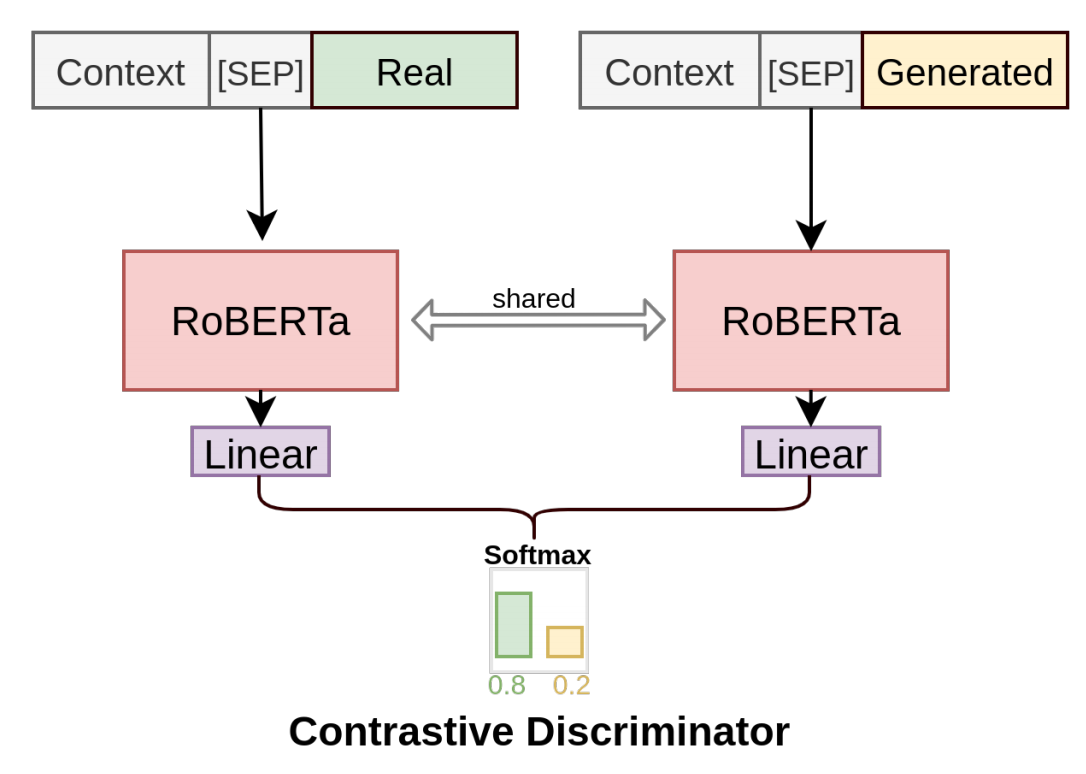

Now, instead of an input of $D_\theta(x,y)$, the Contrastive Discriminator takes in input $D_\theta(\langle x, y_r \rangle, \langle x, y_g \rangle )$, where $\langle x , y_r \rangle$ is the input sequence and the real response and $\langle x, y_g \rangle$ is the same input sequence but with the generated response. The output of the Discriminator is then a score about how good the generated sequence is in regards to the real sequence. It is then optimized with the following:
\begin{align}
h_r &= RoBERTa(\langle x, y_r \rangle) \\
h_g &= RoBERTa(\langle x, y_g \rangle) \\
p_r, p_g &= softmax(W_t[h_r;h_g]) \\
\end{align}
We can then optimize the discriminator with cross-entropy to maximize the real probability $p_g$ and output the generated probability as the reward signal to the generator to iterate on. 

## GPT-2
[GPT-2 Paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

[GPT-2 Link](https://openai.com/blog/better-language-models/)

GPT-2 or **G**enerative **P**re-trained **T**ransformer **2** is the most recent NLP model developed by OpenAI. Similar to RoBERTa, it is also an extremely large pretrained model for textual applications in all domains. However, GPT-2 specializes in text generation, making it a good choice for the Generator network of the architecture. GPT-2 is pre-trained using 40GB of internet text and the model used for this architecture is GPT-2 Small with 117 million parameters and 12 layers in the encoder-decoder transformer structure.

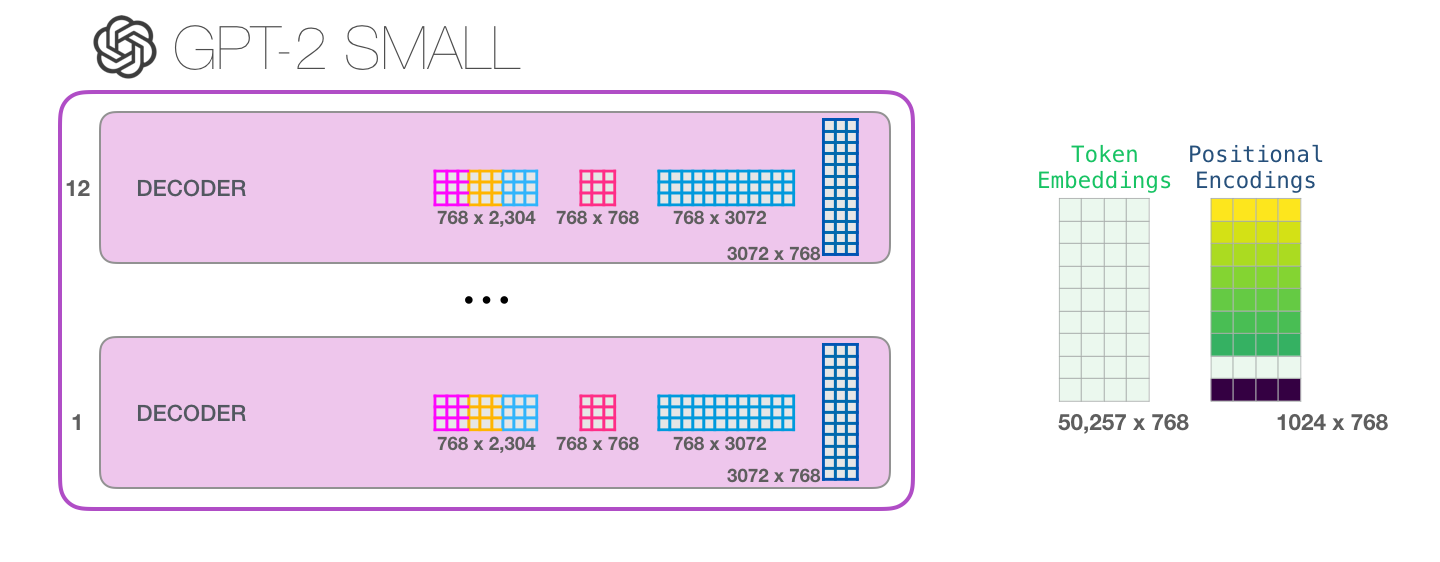

We must modify the architecture of GPT-2 to use it in the GAIL model. I borrowed an idea from the paper on how to set up the generator network of the GAIL using a configuration of GPT-2. The main motivation for this change is because in a traditional GAIL, the generator network estimates a policy that is then translated to a similarity/occupancy measure that the discriminator can classify. Since a policy is simply a set of states and corresponding actions, this works well for most applications. However, in text generation, the possible action space for any policy is too large, since the action space would be any combination of the 40GB vocabulary which GPT-2 used to train. If we were to use a traditional GAIL generator for this application, the model will not be stable.

The architecture for the Generator in this architecture is as follows:
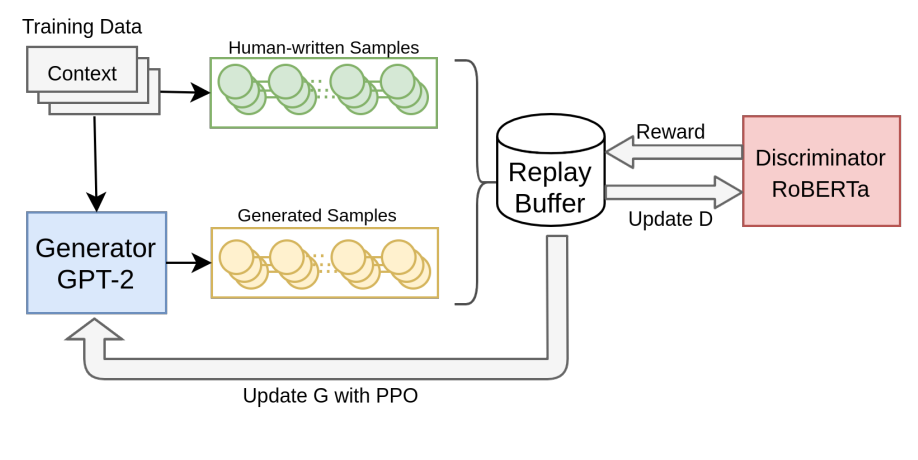


The Generator is optimized with PPO through the replay buffer. We define the probability of a text sequence as the joint probability of all the tokens:

$$G_\theta(y_{1:T}|x) = \prod_{t=0}^T G_\theta(y_t | y_{<t}, x),$$

where $y_{1:T}$ is a text sequence, $T$ is the sequence length, and $y_t$ is the word at time step $t$. We then sample from this distribution to acquire the generated sequences. Then we maximize the expected reward with policy gradient:
$$\mathbb{E}_{y \sim G_\theta}[\nabla_\theta \log G_\theta(x)\hat{R}_y],$$

where $\hat{R}_y$ is the normalized reward. The original GAIL paper used TRPO, but I decided to use PPO it is more stable and has lower variance. We can maximize the expected reward with PPO here. 

Note that the overall loss function still remains a two-player minimax loss function, simply the architecture of the generator and discriminator networks are changing. The loss function for this implementation is identical to a GAN:

$$\min_{G_{\theta}} \max_{D_{\phi}} \mathbb{E}_{p_{\text{real}}}[D_{\phi}(x,y)] + \mathbb{E}_{G_{\theta}}[1-D_{\phi}(x, G_{\theta}(x))],$$

where $G_\theta$ and $D_\phi$ denote the Generator and Discriminator networks, parameterized by $\theta$ and $\phi$ respectively. 

## Training Data and Output Classes

For this initial model of testing empathy using GAIL, I used data from [Empathetic Dialogues](https://github.com/facebookresearch/EmpatheticDialogues/tree/master/empchat), [DailyDialog](https://github.com/Sanghoon94/DailyDialogue-Parser), and [OMG-Empathy](https://www2.informatik.uni-hamburg.de/wtm/omgchallenges/omg_empathy.html) datasets.

To simplify the task, instead of trying to have the model sustain a conversation and fully generate responses to inputs, I decided to use a set of output classes that correspond to the emotion that an empathetic responder may respond with. The emotions I wanted the classes to show is:


**[afraid, proud, terrified,
       joyful, angry, sad, grateful,
       embarrassed, excited, annoyed, lonely, ashamed, guilty,
       surprised, confident, furious, disappointed,
       disgusted, anticipating, anxious,
       hopeful, content, impressed, devastated]**

There are a total of 25 emotion classes, which correspond to the following output sentences:


[
'Wow! That seems quite scary!', 

'Wow! That caught you by surprise',

"Awesome! It seems like you're really excited",

'Sounds like a bummer.', 

"Oh, no! I'm sorry to hear that",

"That may have been embarrassing, but I'm sure you'll be fine!",

'It seems like you are feeling afraid. Do you need some help?',

'You must be so proud!', 

'Yes, that truly is amazing',

"Great! I'm glad you are happy!", 

'Great! You seem quite hopeful.',

'I want you to know that you are never alone, I am always here when you need me.',

'Sorry to hear that, that must have been an inconvenience.',

'It seems like you are feeling angry. Is there any way I can help?',

"Don't beat yourself up",

"I'm sure you don't have to feel too anxious."]

** Must be on GPU session for CUDA to work **

In [1]:
!nvidia-smi

Mon Nov  9 16:32:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/TextGAIL-master\ 2/

/content/drive/My Drive/TextGAIL-master 2


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 19.1MB 161kB/s 
     |████████████████████████████████| 501kB 48.1MB/s 
     |████████████████████████████████| 122kB 48.6MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 2.9MB 47.4MB/s 
     |████████████████████████████████| 1.3MB 46.7MB/s 
     |████████████████████████████████| 1.1MB 49.4MB/s 
     |████████████████████████████████| 133kB 55.1MB/s 
     |████████████████████████████████| 3.7MB 48.6MB/s 
     |████████████████████████████████| 890kB 49.4MB/s 
     |████████████████████████████████| 112kB 44.8MB/s 
     |████████████████████████████████| 296kB 52.1MB/s 
     |████████████████████████████████| 143kB 59.2MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 6.7MB 49.3MB/s 
  Created wheel for fast-bleu: filename=fast_bleu-0.0.86-cp36-cp36m-linux_x86_64.whl size=581261 sha256=4d1f6e4c2eda83df0124728324bbda5e71c0503023f4c4fdc83d0ad6713

In [5]:
!git clone https://github.com/qywu/apex


fatal: destination path 'apex' already exists and is not an empty directory.


In [6]:
%cd apex

/content/drive/My Drive/TextGAIL-master 2/apex


In [7]:
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./


/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-zrlk1_zd
Created temporary directory: /tmp/pip-req-tracker-uqlzgmn9
Created requirements tracker '/tmp/pip-req-tracker-uqlzgmn9'
Created temporary directory: /tmp/pip-install-qxat53zn
Processing /content/drive/My Drive/TextGAIL-master 2/apex
  Created temporary directory: /tmp/pip-req-build-st7_9aej
  Added file:///content/drive/My%20Drive/TextGAIL-master%202/apex to build tracker '/tmp/pip-req-tracker-uqlzgmn9'
    Running setup.py (path:/tmp/pip-req-build-st7_9aej/setup.py) egg_info for package from file:///content/drive/My%20Drive/TextGAIL-master%202/apex
    Running command python setup.py egg_info
    torch.__version__  =  1.7.0+cu101
    running egg_info
    creating /tmp/pip-req-build-s

In [8]:
%cd ..

/content/drive/My Drive/TextGAIL-master 2


In [9]:
%cd Conditional/TextGAIL/

/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL


In [10]:
!git clone https://github.com/qywu/TorchFly


fatal: destination path 'TorchFly' already exists and is not an empty directory.


In [22]:
%cd TextGAIL/

/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL


In [23]:
%cd TorchFly/

/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL/TorchFly


In [24]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/TextGAIL-master%202/Conditional/TextGAIL/TorchFly
  Found existing installation: TorchFly 0.0.1
    Can't uninstall 'TorchFly'. No files were found to uninstall.
  Running setup.py develop for TorchFly


In [13]:
%cd ..

/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL


In [14]:
%cd TextGAIL/

[Errno 2] No such file or directory: 'TextGAIL/'
/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL


In [15]:
!python main.py

2020-11-09 16:39:11.422931: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/usr/local/lib/python3.6/dist-packages/hydra/core/utils.py:204: UserWarning: 
Using config_path to specify the config name is deprecated, specify the config name via config_name
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/config_path_changes
  warnings.warn(category=UserWarning, message=msg)
/usr/local/lib/python3.6/dist-packages/hydra/_internal/hydra.py:71: UserWarning: 
@hydra.main(strict) flag is deprecated and will removed in the next version.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/strict_mode_flag_deprecated
  warnings.warn(message=msg, category=UserWarning)
/usr/local/lib/python3.6/dist-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive task/ROCStories.yaml in file:///content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL/config.
See https://hydra.cc/docs/next/upgrades/0.11_

## Perplexity Error Metric

Perplexity is a NLP-specific error metric used mostly for dialogue/text generation and it essentially measures how confusing the generated text is. If a human can more or less understand the generated text, then the perplexity will be low. Mathematically, perplexity is defined as 
$$\text{Perplexity}(p_M) = \frac{1}{(\prod_{i=1}^T p_M(w_i | w_1 \dots w_{i-1}))^{\frac{1}{t}}}$$
where $p_M$ is a language model with next word $w$ and history $h$ evaluated on a validation/test set = $\{w_1, \dots, w_t\}.$

[Perplexity Paper](https://www.cs.cmu.edu/~roni/papers/eval-metrics-bntuw-9802.pdf)

In [16]:
%pwd

'/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL'

In [26]:
%cd ..

/content/drive/My Drive/TextGAIL-master 2/Conditional


In [27]:
%cd Evaluation/

/content/drive/My Drive/TextGAIL-master 2/Conditional/Evaluation


In [29]:
!git clone https://github.com/qywu/TorchFly

Cloning into 'TorchFly'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 1546 (delta 111), reused 123 (delta 52), pack-reused 1356
Receiving objects: 100% (1546/1546), 6.58 MiB | 14.48 MiB/s, done.
Resolving deltas: 100% (819/819), done.


In [30]:
%cd TorchFly/

/content/drive/My Drive/TextGAIL-master 2/Conditional/Evaluation/TorchFly


In [31]:
!pip install -e .

Obtaining file:///content/drive/My%20Drive/TextGAIL-master%202/Conditional/Evaluation/TorchFly
  Found existing installation: TorchFly 0.0.1
    Can't uninstall 'TorchFly'. No files were found to uninstall.
  Running setup.py develop for TorchFly


In [38]:
%cd Conditional/TextGAIL/

/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL


In [41]:
%cd TorchFly/

/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL/TorchFly


In [54]:
%cd Evaluation/

/content/drive/My Drive/TextGAIL-master 2/Conditional/Evaluation


In [82]:

import hydra
import hydra.experimental
import numpy as np
import tqdm
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer
from omegaconf import DictConfig

from torchfly.text.decode import TransformerDecoder
from torchfly.common import set_random_seed, move_to_device

from configure_dataloader import DataLoaderHandler
from model import Generator, TextGAILModel

import logging

In [83]:

random_seed = 1
set_random_seed(random_seed)

1

In [84]:
%pwd

'/content/drive/My Drive/TextGAIL-master 2/Conditional/Evaluation'

In [ ]:
hydra.experimental.initialize("config")

In [101]:
config = hydra.experimental.compose("config.yaml")

/usr/local/lib/python3.6/dist-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive task/ROCStories.yaml in file:///content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL/config.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/usr/local/lib/python3.6/dist-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive training/ROCStories.yaml in file:///content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL/config.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/usr/local/lib/python3.6/dist-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive model/roberta-tokenized-gpt2.yaml in file:///content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL/config.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_

In [64]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [100]:
print(config.pretty())

/usr/local/lib/python3.6/dist-packages/omegaconf/basecontainer.py:232: UserWarning: cfg.pretty() is deprecated and will be removed in a future version.
Use OmegaConf.to_yaml(cfg)

  category=UserWarning,


task:
  name: ROCStories
  data_dir: ../../data/ROCStories
  weights_path: /root/.cache/torchfly/models/roberta-tokenized-gpt2.pth
training:
  random_seed: 1
  num_gpus_per_node: 1
  batch_size: 32
  resume:
    resume: false
    resume_model: true
    resume_optimizer: true
    resume_scheduler: true
    resume_rng_state: true
  total_num:
    epochs: -1
    update_steps: 750
  validation:
    steps_interval: 50
  checkpointing:
    directory: Checkpoints
    steps_interval: 750
    seconds_interval: -1
    num_checkpoints_to_keep: 1000
    keep_checkpoint_every_num_seconds: 86400
  logging:
    level: INFO
    steps_interval: -1
    seconds_interval: 2
  optimization:
    fp16: false
    fp16_opt_level: O1
    optimizer_name: AdamW
    learning_rate: 1.0e-05
    gradient_accumulation_steps: 1
    weight_decay: 0.01
    max_gradient_norm: -1.0
    warmup:
      scheduler_name: WarmupLinear
      warmup_steps: 1000
model:
  initializer_range: 0.02
  layer_norm_epsilon: 1.0e-05
  n_ctx:

In [65]:
pwd

'/content/drive/My Drive/TextGAIL-master 2/Conditional/Evaluation'

In [102]:
dataloader_handler = DataLoaderHandler(config)

In [103]:
test_dataloader = dataloader_handler.test_dataloader(config)

In [118]:
%pwd

'/content/drive/My Drive/TextGAIL-master 2/Conditional/Evaluation'

In [104]:
collate_fn = test_dataloader.dataset.collate_fn

In [77]:
device = torch.device("cuda")

In [78]:
model = TextGAILModel(config)
model = model.cuda()

File exists: /root/.cache/torchfly/models/roberta-tokenized-gpt2.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.decoder.weight'])


In [79]:
decoder = TransformerDecoder(config.decode)
decoder.register_generator(model.generator.decoder)
decoder.register_tokenizer(tokenizer)
decoder.prepare_model_inputs_for_generation = model.generator.prepare_model_inputs_for_generation

In [105]:
print(config.task.textgail_weights_path)

/root/.cache/torchfly/models/roberta-tokenized-gpt2.pth


In [106]:
textgail_weights = torch.load(config.task.textgail_weights_path)
model.load_state_dict(textgail_weights, strict=False)

_IncompatibleKeys(missing_keys=['generator.encoder.transformer.wte.weight', 'generator.encoder.transformer.wpe.weight', 'generator.encoder.transformer.h.0.ln_1.weight', 'generator.encoder.transformer.h.0.ln_1.bias', 'generator.encoder.transformer.h.0.attn.c_attn.weight', 'generator.encoder.transformer.h.0.attn.c_attn.bias', 'generator.encoder.transformer.h.0.attn.c_proj.weight', 'generator.encoder.transformer.h.0.attn.c_proj.bias', 'generator.encoder.transformer.h.0.ln_2.weight', 'generator.encoder.transformer.h.0.ln_2.bias', 'generator.encoder.transformer.h.0.mlp.c_fc.weight', 'generator.encoder.transformer.h.0.mlp.c_fc.bias', 'generator.encoder.transformer.h.0.mlp.c_proj.weight', 'generator.encoder.transformer.h.0.mlp.c_proj.bias', 'generator.encoder.transformer.h.1.ln_1.weight', 'generator.encoder.transformer.h.1.ln_1.bias', 'generator.encoder.transformer.h.1.attn.c_attn.weight', 'generator.encoder.transformer.h.1.attn.c_attn.bias', 'generator.encoder.transformer.h.1.attn.c_proj.wei

In [107]:
temperatures = (np.arange(10) + 1) / 10.0

In [131]:
temperatures

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

'/content/drive/My Drive/TextGAIL-master 2/Conditional/Evaluation'

In [109]:
for temperature in temperatures:
    f_write = open(f"{config.task.name}/textgail_{temperature}_{random_seed}.txt", "w")

    for batch in tqdm.tqdm(test_dataloader):
        batch = collate_fn(batch)
        batch = move_to_device(batch, device)

        ground_truth = batch["target_text"]

        results = decoder.generate(batch["source_token_ids"], temperature=temperature)
        generated = []

        for i in range(len(results["tokens"])):
            res = tokenizer.decode(results["tokens"][i][0][1:-1].tolist())
            generated.append(res)

        for gt, gen in zip(ground_truth, generated):
            f_write.write(json.dumps([gt, gen]))
            f_write.write("\n")
        
    f_write.close()

  0%|          | 0/59 [00:00<?, ?it/s]/content/drive/My Drive/TextGAIL-master 2/Conditional/TextGAIL/TorchFly/torchfly/text/decode/transformer_decoder.py:629: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  keeped_sequence_indices = (~check_if_eos).nonzero().squeeze(1)
100%|██████████| 59/59 [01:21<00:00,  1.38s/it]


## Outputs

I wasn't able to set the model up on ParlAI yet to be fully interactive, but I was able to see what the model generated for the test set inputs. 




Here are some examples of the prompt, ground truth, and the generated output:

--- 


Input: "I'm scared of bugs."

Ground Truth: "Wow! That seems quite scary!"

Generated Output: "I'm scared of bugs too."


--- 


Input: "One of the most blissed out moment of time I remember in life was right after the birth of my first child."

Ground Truth: "Great! I'm glad you are happy!"

Generated Output: "It was a moment of joy and happiness that I could not have imagined"

---

Input: "I've read an article about a little newborn babygirl. She died because she was premature and she had problems breathing on her own when she was born but parents didn't take her to the hospital because they don't believe in medication"

Ground Truth:  "Oh, no! I'm sorry to hear that"

Generated Output: "I'm not sure if this is a good thing or not."

--- 

Input: "I'm going to see my parents soon!"

Ground Truth: "Great! I'm glad you are happy!"

Generated Output: "Oh, I'm sorry, I'm sorry."

--- 

Input: "All my friends live in a different country"

Ground Truth: "I want you to know that you are never alone, I am always here when you need me."

Generated Output: "I'm not going to tell you how I feel about it."

--- 

Input: "I am annoyed by people who won't return their grocery carts, and just leave them in the parking lot!"

Ground Truth: "Sorry to hear that, that must have been an inconvenience."

Generated Output: "I am also annoyed by people who don't want to return their grocery carts, and just leave them in the parking lot!"

---
Input: "I fell down in a mud puddle today while walking to lunch. I was covered in mud for the rest of the work day."

Ground Truth:  "That may have been embarrassing, but I'm sure you'll be fine!"

Generated Output: "I am not saying that you should be ashamed of yourself."

---
Input: "I've been so upset lately, the house has been a mess and my husband hasn't been helping clean."

Ground Truth: "It seems like you are feeling angry. Is there any way I can help?"

Generated Output: "I'm so sorry for the mess."

---
Input: "I always find it crazy to hear how many people eat out so much. Like we eat out once or twice a month maybe. I can't imagine spending so much on food."

Ground Truth: "Wow! That caught you by surprise."

Generated Output: "I think it's a good thing to have a healthy lifestyle."

---
## Takeaways

The model seems to generate its own text that can sometimes be nothing like the output classes that I set up. Sometimes this new text is better than the label I set up, but other times, it does not seem to be relevant or even provides the wrong emotion. 

I think that these problems will likely go away with longer input data, I am looking into incorporating longer stretches of conversation as input instead of a single sentence so that RoBERTa and GPT-2 can train properly. The other issue is that since I am using these pretrained models, the reason why we are getting outputs that are nothing like the output classes is because the pre-trained models is using the 40GB of internet data to generate responses. This may be helpful at times, but it is also quite harmful, because there is no restriction on only using empathetic data. There can also be chances of profanity and inappropriate responses if we use such large scale pre-trained language models. 

Overall, this was a great first step and we finally got our first generated outputs from our empathy-based AI with the novel GAIL model. 

In [110]:
print(config.task.textgail_weights_path)

/root/.cache/torchfly/models/roberta-tokenized-gpt2.pth


In [111]:
textgail = []
for temperature in temperatures:
    for batch in tqdm.tqdm(test_dataloader):
        batch = collate_fn(batch)
        batch = move_to_device(batch, device)
        batch["temperature"] = temperature

        model.predict(batch)
    metrics = model.get_metrics(reset=True)
    textgail.append(metrics['perplexity'])

100%|██████████| 59/59 [00:15<00:00,  3.70it/s]


In [112]:
print(textgail)


[111.37123780331369, 111.37123780331369, 111.37123780331369, 111.37123780331369, 111.37123780331369, 111.37123780331369, 111.37123780331369, 111.37123780331369, 111.37123780331369, 111.37123780331369]


In [118]:
config.task.name = "empathy"


In [120]:
with open(f"{config.task.name}_perplexity.txt", "w") as f:
     line = json.dumps({"textgail": textgail})
     f.write(line)
     f.write("\n")

In [117]:
%ls

'Compute Perplexity.ipynb'   Generation.ipynb           ROCStories/
 config/                     model.py                   TorchFly/
 configure_dataloader.py    'Quality Diversity.ipynb'


In [121]:

with open(f"{config.task.name}_perplexity.txt") as f:
    line = f.readline()
    line = json.loads(line)
    textgail = line["textgail"]

In [122]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [124]:
import matplotlib.pyplot as plt

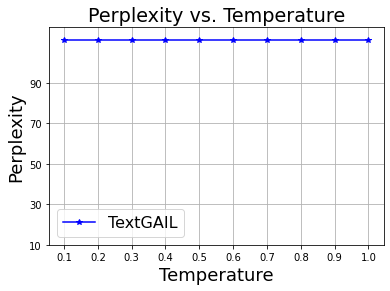

In [126]:
fig=plt.figure()
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 16})

ax.plot(temperatures, textgail, marker="*", color="b")
ax.legend(["TextGAIL"])
ax.set_xlabel("Temperature", fontsize=18)
ax.set_ylabel("Perplexity", fontsize=18)
ax.set_title(f"Perplexity vs. Temperature")

major_ticks = np.arange(10, 100, 20)
ax.set_yticks(major_ticks)
ax.set_xticks(temperatures)

ax.grid("on")

plt.savefig(f"{config.task.name} perplexity.png", dpi=300, pad_inches=0.1, bbox_inches='tight')